In [1]:
%load_ext autoreload
%autoreload 2

from discontinuum.providers import usgs
from discontinuum.utils import aggregate_to_daily

import xarray as xr

In [2]:
# setup

# Choptank River at Greensboro, MD
site = "01491000" 
start_date = "1979-10-01"
end_date = "2011-09-30"

# SF Coeur D Alene River 
#site = "12413470"
#start_date = "1988-10-01" 
#end_date = "2021-09-30" 

characteristic = 'Inorganic nitrogen (nitrate and nitrite)'
#characteristic = 'Phosphorus'
fraction = 'Dissolved'

In [3]:
# download data

daily = usgs.get_daily(site=site, start_date=start_date, end_date=end_date)
samples = usgs.get_samples(site=site, start_date=start_date, end_date=end_date, characteristic=characteristic, fraction=fraction)

samples = aggregate_to_daily(samples)

training_data = xr.merge([samples, daily], join='inner')

/Users/thodson/micromamba/envs/discontinuum-dev/lib/python3.11/site-packages/dataretrieval/wqp.py:494: UserWarning: USGS discrete water quality data availability and format are changing. Beginning in March 2024 the data obtained from legacy profiles will not include new USGS data or recent updates to existing data. To view the status of changes in data availability and code functionality, visit: https://doi-usgs.github.io/dataRetrieval/articles/Status.html. If you have additional questions about these changes, email CompTools@usgs.gov.
  warnings.warn(('USGS discrete water quality data availability '
/Users/thodson/Desktop/dev/software/discontinuum/discontinuum/providers/usgs.py:253: UserWarning: Censored values have been removed from the dataset.
  warnings.warn("Censored values have been removed from the dataset.")


In [4]:
%%time
# fit model

from discontinuum.models import LoadestGP

model = LoadestGP()
model.fit(target=training_data['concentration'], covariates=training_data[['time','flow']])

MAP ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2% 0:09:28 logp = -942.07, ||grad|| = 0.38789

CPU times: user 24.9 s, sys: 4.55 s, total: 29.5 s
Wall time: 28.9 s


<Axes: xlabel='time', ylabel='Inorganic nitrogen (nitrate\nand nitrite) [mg/l as N]'>

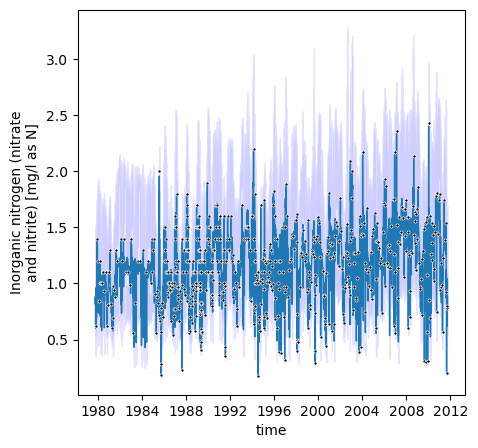

In [5]:
# plot result

model.plot(daily[['time','flow']])

In [6]:
sim = model.sample(daily[['time','flow']])

In [63]:
flux = sim * daily['flow'] * 86400 * 1e-6 #kg/day
flux.attrs = samples['concentration'].attrs
flux.attrs['units'] = 'kilotons N per year'

In [64]:
flux.attrs

{'pcode': '00631',
 'standard_name': 'concentration',
 'long_name': 'Inorganic nitrogen (nitrate and nitrite)',
 'units': 'kilotons N per year',
 'suffix': None,
 'conversion': 1.0}

[[Text(1, 0, '1979'),
  Text(2, 0, '1980'),
  Text(3, 0, '1981'),
  Text(4, 0, '1982'),
  Text(5, 0, '1983'),
  Text(6, 0, '1984'),
  Text(7, 0, '1985'),
  Text(8, 0, '1986'),
  Text(9, 0, '1987'),
  Text(10, 0, '1988'),
  Text(11, 0, '1989'),
  Text(12, 0, '1990'),
  Text(13, 0, '1991'),
  Text(14, 0, '1992'),
  Text(15, 0, '1993'),
  Text(16, 0, '1994'),
  Text(17, 0, '1995'),
  Text(18, 0, '1996'),
  Text(19, 0, '1997'),
  Text(20, 0, '1998'),
  Text(21, 0, '1999'),
  Text(22, 0, '2000'),
  Text(23, 0, '2001'),
  Text(24, 0, '2002'),
  Text(25, 0, '2003'),
  Text(26, 0, '2004'),
  Text(27, 0, '2005'),
  Text(28, 0, '2006'),
  Text(29, 0, '2007'),
  Text(30, 0, '2008'),
  Text(31, 0, '2009'),
  Text(32, 0, '2010'),
  Text(33, 0, '2011')]]

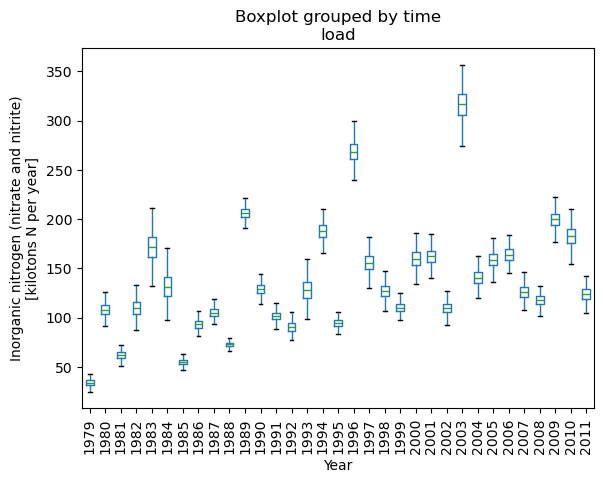

In [65]:
#compute load then do
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
annual_flux = flux.resample(time='YE').sum()

# plot
annual_flux.to_dataframe(name='load').boxplot(by='time', showfliers=False, grid=False, ax=ax)
ax.set_ylabel('{}\n[{}]'.format(flux.attrs['long_name'], flux.attrs['units']))
ax.set_xlabel('Year')
ax.tick_params(axis='x', labelrotation=90)

#xticks = annual_flux.time.dt.year.values[::5]
#ax.set_xticks(ticks=xticks, labels=xticks)
ax.set(xticklabels=annual_flux.time.dt.year.values)
#for label in ax.xaxis.get_ticklabels()[::5]:
#    label.set_visible(False)

<Axes: title={'center': 'load'}, xlabel='[time]'>

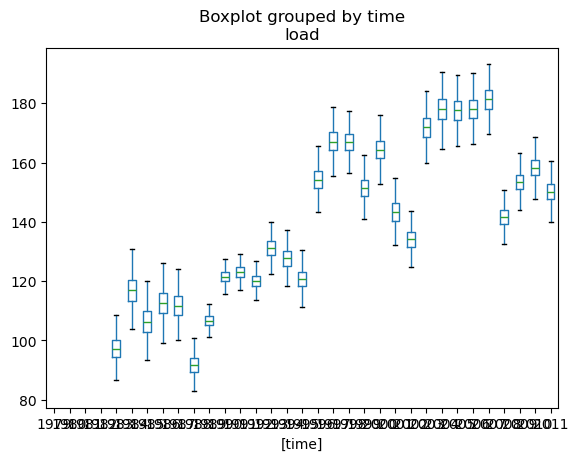

In [62]:
flux_5yr = annual_flux.rolling(time=5).mean()
flux_5yr['time'] = flux_5yr.time.dt.year
flux_5yr.to_dataframe(name='load').boxplot(by='time', showfliers=False, grid=False)